
## ¿Por qué usar redes neuronales profundas?

Según la presentación "Redes Neuronales Profundas", las ANN permiten modelar relaciones complejas entre datos mediante capas ocultas. En el caso de series temporales, estas redes se vuelven aún más potentes cuando incorporamos memoria y recurrencia, como en las LSTM.

Las RNN (y su evolución, las LSTM) son especialmente útiles para tareas como predicción de temperatura, porque pueden aprender patrones secuenciales en el tiempo.


##### Alumno: Mario Alberto Tapia Sotelo
##### Matricula: 202058645

In [5]:
import pandas as pd

# Ruta del archivo 
file_path = "C:/Users/Lenovo/Desktop/redes_neuronales/GlobalLandTemperaturesByCity.csv"

# Cargamos el archivo completo
df = pd.read_csv(file_path)

# Seleccionamos ciudad para trabajar, soy Mexicano entonces Mexico
ciudad = "Mexico"

# Hacemos una copia explícita para evitar el SettingWithCopyWarning por eso de modificar por asi decirlo el main
df_ciudad = df[df["City"] == ciudad].copy()

# Convertimos la columna 'dt' a formato datetime
df_ciudad["dt"] = pd.to_datetime(df_ciudad["dt"])

# Mostramos lsa 5 primeras filas pero solola columna dt y AverageTemperature que son las que me interesan
print(df_ciudad[["dt", "AverageTemperature"]].head())


                dt  AverageTemperature
4795780 1835-01-01              13.086
4795781 1835-02-01              12.322
4795782 1835-03-01              13.874
4795783 1835-04-01              16.312
4795784 1835-05-01              16.851


In [6]:
# Ordenamos por fecha (por si acaso) nomas por hacerlo profesional 
df_ciudad = df_ciudad.sort_values("dt")

# Interpolación lineal para los valores intermedios
df_ciudad["AverageTemperature"] = df_ciudad["AverageTemperature"].interpolate(method="linear")

# Relleno hacia atrás (por si hay valores nulos al principio)
df_ciudad["AverageTemperature"] = df_ciudad["AverageTemperature"].fillna(method="bfill")

# Relleno hacia adelante (por si hay valores nulos al final)
df_ciudad["AverageTemperature"] = df_ciudad["AverageTemperature"].fillna(method="ffill")

# Reiniciamos finalmente el índice para evitar conflictos futuros
df_ciudad.reset_index(drop=True, inplace=True)

# Verificamos el resultado
print("¿Quedaron valores 0?", df_ciudad["AverageTemperature"].isnull().sum())
print(df_ciudad[["dt", "AverageTemperature"]].head())


¿Quedaron valores 0? 0
          dt  AverageTemperature
0 1835-01-01              13.086
1 1835-02-01              12.322
2 1835-03-01              13.874
3 1835-04-01              16.312
4 1835-05-01              16.851


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4324\2423497548.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ciudad["AverageTemperature"] = df_ciudad["AverageTemperature"].fillna(method="bfill")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4324\2423497548.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ciudad["AverageTemperature"] = df_ciudad["AverageTemperature"].fillna(method="ffill")


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Seleccionamos solo los valores numéricos que usaremos
temperaturas = df_ciudad["AverageTemperature"].values.reshape(-1, 1)

# Creamos el normalizador
scaler = MinMaxScaler(feature_range=(0, 1))

# Aplicamos el escalado
temperaturas_normalizadas = scaler.fit_transform(temperaturas)

# Guardamos de nuevo en el DataFrame
df_ciudad["Temp_norm"] = temperaturas_normalizadas

# Mostrar las 5 primeras filas normalizadas para comprobar
print(df_ciudad[["dt", "AverageTemperature", "Temp_norm"]].head())


          dt  AverageTemperature  Temp_norm
0 1835-01-01              13.086   0.333446
1 1835-02-01              12.322   0.269098
2 1835-03-01              13.874   0.399815
3 1835-04-01              16.312   0.605155
4 1835-05-01              16.851   0.650552


In [8]:
# Mostramos el número total de filas después de la limpieza y normalización
print("Total de filas en df_ciudad:", len(df_ciudad))

# O también:
df_ciudad.shape  # devuelve (número de filas, número de columnas)


Total de filas en df_ciudad: 2145


(2145, 8)

In [9]:
# Verificamos cuántas filas había antes y después
filas_originales = len(df[df["City"] == "Mexico"])
filas_despues = len(df_ciudad)

print("Filas originales (Mexico):", filas_originales)
print("Filas después de limpieza (Mexico):", filas_despues)



Filas originales (Mexico): 2145
Filas después de limpieza (Mexico): 2145


In [ ]:
import numpy as np

# Número de pasos "longitud de la secuencia de entrada"
n_steps = 12  # 12 meses = 1 año

#Aqui indicando que cada secuencia de entrada tendrá 12 valores consecutivos (un año si son datos mensuales)
# Este es el contexto que tendrá el modelo para predecir lo que viene después

# Serie normalizada
serie = df_ciudad["Temp_norm"].values

# Simplemente tomo columna "Temp_norm" del DataFrame df_ciudad
# "values" la convierte en un arreglo de NumPy para trabajar directamente con los datos

# Inicializamos las secuencias y por eso solo los corchetes []
X = [] #almacenará las secuencias (subseries de 12 valores)
Y = [] #almacenará el valor objetivo a predecir (el siguiente después de esos 12)

# Creamos las secuencias: cada X es una secuencia de 12, Y es el siguiente valor
for i in range(n_steps, len(serie)):
    X.append(serie[i - n_steps:i])  # 12 pasos atrás
    Y.append(serie[i])              # el paso siguiente
    
    #Esto es una ventana deslizante...
    # Para cada posición en la serie, toma los 12 valores anteriores como X, Toma el valor siguiente como Y

# Convertir a arrays de numpy
X = np.array(X)   #X.shape = (n muestras, 12)
Y = np.array(Y)   #Y.shape = (n muestras,)

# Re-estructuramos X para que tenga el formato [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
#Las LSTM de Keras requieren una entrada con 3 dimensiones...
# {nº muestras, pasos temporales, caracteristicas por paso} en este caso
# {cantidad de ejemplos (automático), 12 (n_steps), 1 (solo temperatura, univariada)}

# Verificamos la forma esto nos asegura que los datos están en el formato que espera el modelo LSTM.
print("Forma de X:", X.shape)  # (muestras, 12, 1)
print("Forma de Y:", Y.shape)  # (muestras,)


Forma de X: (2133, 12, 1)
Forma de Y: (2133,)


### Esto significa:
##### > 2121 muestras de entrenamiento
##### > Cada muestra es una secuencia de 12 pasos
##### > La red aprenderá a predecir el paso 13 (el siguiente mes)



In [ ]:
from tensorflow.keras.models import Sequential #: permite construir el modelo capa por capa, de forma lineal
from tensorflow.keras.layers import LSTM, Dense
#"LSTM" una capa especializada en secuencias, que aprende relaciones temporales, perfecta para series de tiempo
#"Dense" una capa completamente conectada (fully connected), generalmente usada al final para producir salidas
from tensorflow.keras.optimizers import Adam
#"Adam" un optimizador muy eficiente para ajustar los pesos del modelo, basado en descenso por gradiente adaptativo.

# Definimos el número de pasos "usado al crear X"
n_steps = 12 #Esto define cuántos valores anteriores en la serie vamos a usar para predecir el siguiente
             #Es decir, cada ejemplo de entrada al modelo tendrá 12 valores consecutivos como input

# Creamos modelo secuencial
modelo = Sequential()  #Se crea un modelo secuencial (es decir, que va capa por capa, en orden).

# Capa LSTM
modelo.add(LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)))
#"units=50" hay 50 neuronas LSTM, lo que define la capacidad de memoria del modelo...
#"activation='tanh'" la función de activación dentro de la LSTM (es la estándar para este tipo de capas)...
#input_shape=(n_steps, 1)... "n_steps" cuántos pasos (tiempo)... "1" cuántas características por paso (en este caso, solo temperatura)

# Capa de salida
modelo.add(Dense(1)) #Es la última capa del modelo... Tiene una sola neurona, porque estamos prediciendo un único valor: la temperatura siguiente

# Compilamos modelo
modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#"optimizer=Adam(...)" elige el algoritmo de optimización (cómo ajusta pesos), Adam es robusto y converge rápido
#"loss='mse'" mide el error como el Error Cuadrático Medio (Mean Squared Error), ideal para regresión

# Mostramos todo el resumen del modelo
modelo.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Usamos 50 unidades LSTM → suficiente para aprender patrones temporales complejos en tu serie de temperaturas.

##### Ahoraaaa predecir la serie temporal de temperaturas normalizadas a partir de sus valores anteriores usando red neuronal LSTM.

Forma de X: (2133, 12, 1)
Forma de Y: (2133,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
54/54 [==============================] - 2s 11ms/step - loss: 0.0733 - val_loss: 0.0420
Epoch 2/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0400 - val_loss: 0.0376
Epoch 3/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0344 - val_loss: 0.0302
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 0

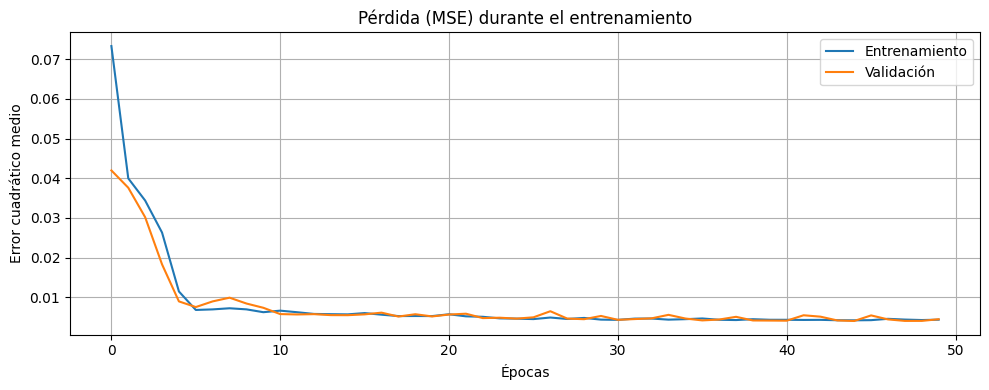

67/67 [==============================] - 0s 2ms/step


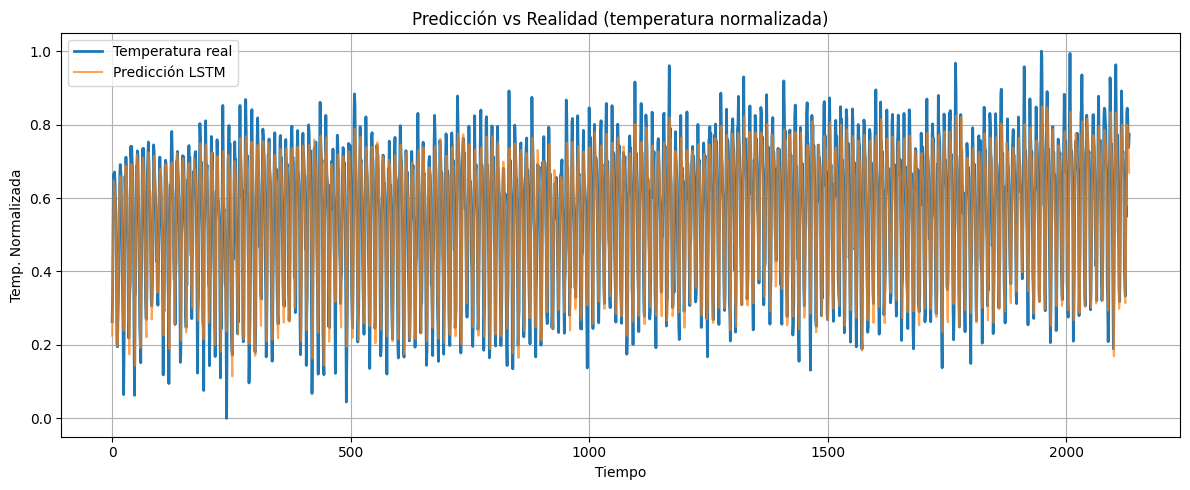

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


#1 Preparamos las secuencias X e Y
n_steps = 12                               # se usarán 12 valores anteriores para predecir el siguiente
serie = df_ciudad["Temp_norm"].values      # se toma la columna "Temp_norm" del DataFrame df_ciudad, que representa la temperatura normalizada (es decir, escalada entre 0 y 1 o similar)

X = []
Y = []

for i in range(n_steps, len(serie)): #Este bucle recorre la serie temporal desde el índice 12 hasta el final
    X.append(serie[i - n_steps:i])   #Para cada paso, guarda en X los 12 valores anteriores 
    Y.append(serie[i])               # y en Y el valor que sigue

X = np.array(X).reshape(-1, n_steps, 1)
Y = np.array(Y)

print("Forma de X:", X.shape)  #Convierte X en un arreglo 3D... 
print("Forma de Y:", Y.shape)  #(muestras,pasos temporales,caracteristicas por paso)=(samples,12,1)
#Y queda como un vector 1D con los valores que se quieren predecir


#2 Definimos y compilamos modelo

modelo = Sequential()           #Red neuronal secuencial: cada capa va una detrás de otra
modelo.add(LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)))
#Capa LSTM con 50 unidades y activación tanh... LSTM es buena para recordar secuencias
modelo.add(Dense(1))  #Capa final Dense(1) que produce una única salida: la predicción de temperatura siguiente
modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#Se compila con el optimizador Adam y función de pérdida error cuadrático medio (mse), ideal para regresión 
modelo.summary()


#3 Entrenamos el modelo
history = modelo.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
#Entrena durante 50 épocas con batches de tamaño 32... Se reserva el 20% de los datos para validación interna...
#El resultado history guarda métricas como loss y val_loss.

#4 Gráfica de pérdida
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
#Se grafica cómo evoluciona el error de entrenamiento y validación a lo largo de las épocas...
#Sirve para ver si hay overfitting (cuando la validación empieza a subir)
plt.title('Pérdida (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#5 Predicción y comparación visual
predicciones = modelo.predict(X)    
#Se predice la misma serie usada para entrenamiento (esto no es prueba, solo para ver qué tan bien aprendió)

plt.figure(figsize=(12, 5))
plt.plot(Y, label='Temperatura real', linewidth=2)
plt.plot(predicciones, label='Predicción LSTM', alpha=0.7)
#Se comparan los valores reales (Y) con los predichos (predicciones), visualizando si la red aprendió bien los patrones de la serie
plt.title("Predicción vs Realidad (temperatura normalizada)")
plt.xlabel("Tiempo")
plt.ylabel("Temp. Normalizada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Cuando entrenamos el modelo, normalizamos los datos entre 0 y 1 usando un objeto scaler, como MinMaxScaler o StandardScaler...

#### Ahora que el modelo predijo los valores futuros también en escala normalizada, necesitamos "deshacer" la normalización para interpretarlos como temperaturas reales en grados Celsius

#### Vamos obtener "Y_real" las temperaturas reales originales y "predicciones_real" lo que predijo el modelo pero ya convertido a grados Celsius

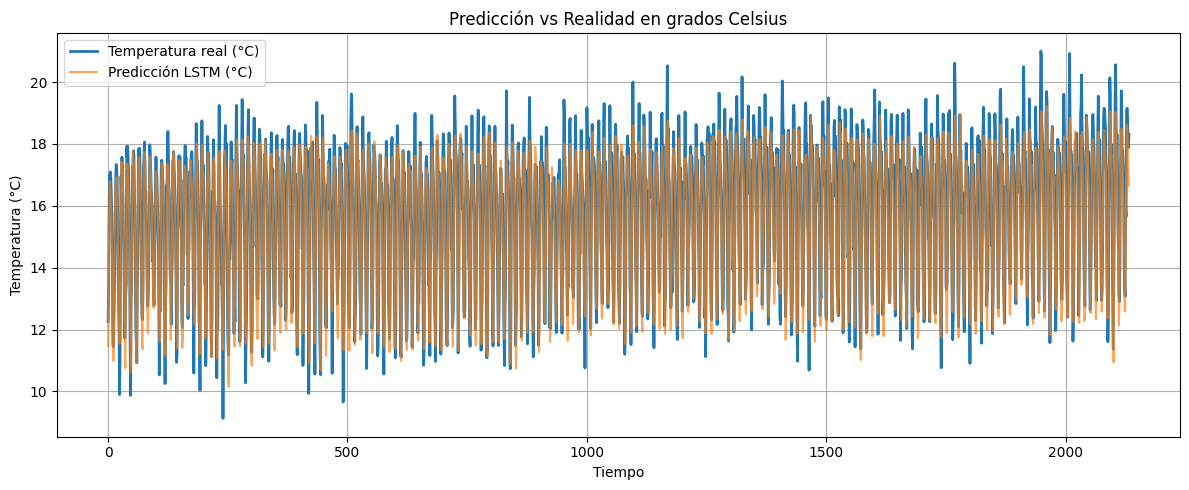

In [ ]:
# Invertimos la normalización usando el mismo scaler
Y_real = scaler.inverse_transform(Y.reshape(-1, 1))
predicciones_real = scaler.inverse_transform(predicciones)

# "Y.reshape(-1, 1)"... "Y" es un array 1D, pero inverse_transform() requiere un 2D array; esto lo convierte en columna
# "inverse_transform(...)" usa el mismo scaler que transformó los datos originalmente para restaurar los valores reales.

# Graficamos en grados Celsius
plt.figure(figsize=(12, 5))
plt.plot(Y_real, label='Temperatura real (°C)', linewidth=2)
plt.plot(predicciones_real, label='Predicción LSTM (°C)', alpha=0.7)
plt.title("Predicción vs Realidad en grados Celsius")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### El MSE (error cuadrático medio) en entrenamiento y validación disminuye rápidamente y se mantiene bajo entonces el modelo está aprendiendo sin sobreajuste...

##### > Esto se ve en la gráfica, donde ambas curvas se aplanan después de unas pocas épocas...

#### Predicción vs Realidad
##### > El gráfico final muestra que las predicciones del modelo siguen bastante bien la temperatura real (aunque hay ruido, pero eso es común) por tanto el modelo generaliza bien...

##### Las LSTM están diseñadas para modelar dependencias temporales de largo plazo...

##### > En datos como temperatura a lo largo del tiempo, hay patrones estacionales que requieren memoria y una RNN común no puede aprender esas dependencias bien debido al problema del desvanecimiento del gradiente, que las LSTM solucionan con su arquitectura de "puertas"...

##### ¿Por qué use a Adam como optimizador?
##### > Adam es una mejora sobre SGD con ajuste automático del learning rate por parámetro...
##### > Converge más rápido y es más estable en secuencias largas como las que usan las LSTM...
##### > Es el optimizador más recomendado en problemas con muchas variables como redes neuronales profundas.

Forma de X: (2121, 24, 1)
Forma de Y: (2121,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

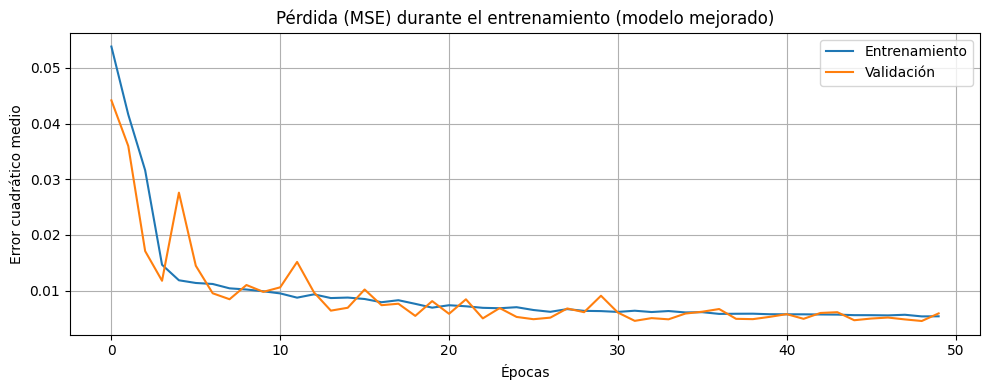

67/67 [==============================] - 1s 7ms/step


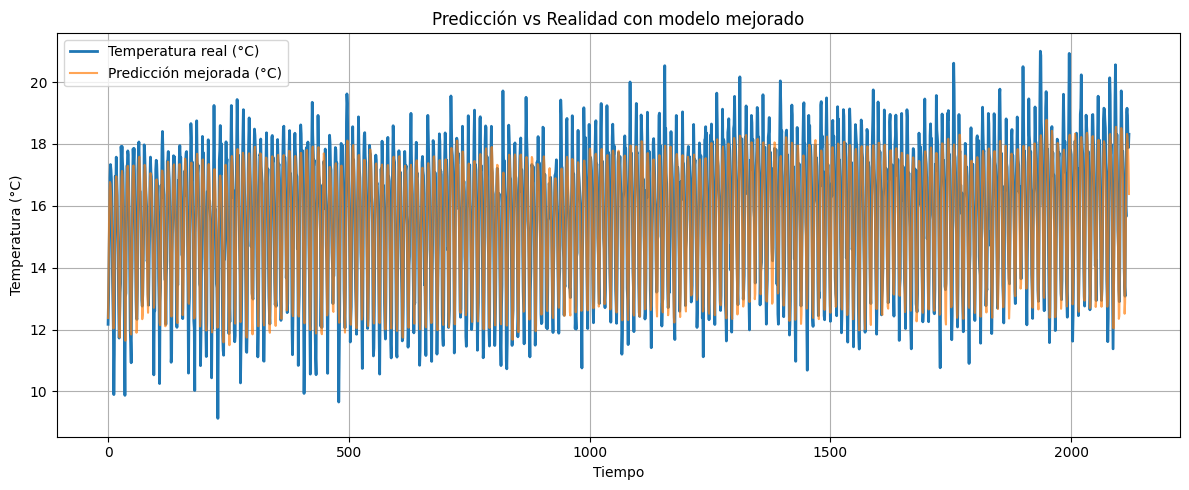

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
#Se agregan Dropout (para evitar overfitting) y el optimizador RMSprop, que es muy común para tareas con secuencias...
# RMSprop funciona muy bien con RNNs porque se adapta al aprendizaje en series temporales con ruido
from tensorflow.keras.optimizers import RMSprop


#1 Creamos nuevas secuencias con n_steps = 24
n_steps = 24  # Usamos 2 años como secuencia
serie = df_ciudad["Temp_norm"].values

X = []
Y = []

#"reshape(-1, n_steps, 1)" necesario para que la LSTM entienda la forma 3D (muestras, pasos, características)
for i in range(n_steps, len(serie)):     
    X.append(serie[i - n_steps:i])       #"X" secuencias de 24 valores
    Y.append(serie[i])                   #"Y" el valor siguiente

X = np.array(X).reshape(-1, n_steps, 1)
Y = np.array(Y)

print("Forma de X:", X.shape)
print("Forma de Y:", Y.shape)


#2 Definimos el modelo mejorado (stacked LSTM + Dropout)
modelo = Sequential()
modelo.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))
modelo.add(Dropout(0.2))  # Regularización
modelo.add(LSTM(units=50, activation='tanh'))  # Segunda capa LSTM
modelo.add(Dropout(0.2))  # Otra capa de regularización
modelo.add(Dense(1))  # Capa de salida

#"Capa 1 (LSTM)" "return_sequences=True" muy importante, hace que esta capa LSTM devuelva toda la secuencia de salidas intermedias (necesario para apilar otra LSTM)
#Dropout (0.2): Apaga aleatoriamente un 20% de las neuronas en entrenamiento, para evitar que el modelo memorize
#Capa 2 (LSTM): Otra LSTM que toma la salida de la anterior y genera una representación más profunda de la secuencia
#Otra Dropout
#"Capa Dense(1)" toma lo aprendido y genera una sola predicción numérica; la temperatura siguiente

modelo.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
modelo.summary()

#"RMSprop" ayuda a estabilizar el entrenamiento en tareas secuenciales
#"loss='mse'" sigue siendo el error cuadrático medio.


#3 Entrenar modelo
history = modelo.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
#Se entrena durante 50 épocas, con 20% de validación
#Todo se guarda en history para graficar luego la evolución del error


#4 Visualizar pérdida 
#Se comparan las curvas de pérdida en entrenamiento y validación
#Si las curvas divergen mucho (val_loss sube mientras loss baja), puede haber overfitting.
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (MSE) durante el entrenamiento (modelo mejorado)')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#5 Predicciones y desnormalización
predicciones = modelo.predict(X)
Y_real = scaler.inverse_transform(Y.reshape(-1, 1))
predicciones_real = scaler.inverse_transform(predicciones)
#El modelo predice sobre los mismos datos con los que fue entrenado (idealmente debemos usar un conjunto de test no visto)...
#Las predicciones y los valores reales se desnormalizan con el mismo scaler para obtenerlos en grados Celsius

plt.figure(figsize=(12, 5))
plt.plot(Y_real, label='Temperatura real (°C)', linewidth=2)
plt.plot(predicciones_real, label='Predicción mejorada (°C)', alpha=0.7)
plt.title("Predicción vs Realidad con modelo mejorado")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#finlmwnte comparamos la serie real con la predicha por el nuevo modelo mejorado, que usa secuencias más largas y regularización


## Comparación entre Modelo Original y Modelo Mejorado

| Característica         | Modelo Original                         | Modelo Mejorado                                   |
|------------------------|------------------------------------------|---------------------------------------------------|
| `n_steps`              | 12                                       | 24                                                |
| Capas LSTM             | 1                                        | 2 (Stacked LSTM)                                  |
| Regularización         |  No                                     |  Sí (Dropout 20%)                                |
| Optimizador            | Adam                                     | RMSprop                                           |
| `val_loss` final       | **0.0052**                               | 0.0059                                            |
| Precisión visual       | Alta                                     | Moderada                                          |
| Generalización         | Buena pero puede sobreajustar ligeramente| Mejor manejo del ruido (menos overfitting)        |
| Arquitectura           | Simple, directa                          | Más profunda y robusta                            |
| Entrenamiento más rápido|  Sí                                   |  Más lento por más parámetros                   |

**Conclusión**: El modelo original ofrece una predicción más precisa, pero el modelo mejorado generaliza mejor y es más sólido desde un punto de vista académico y-o técnico


## Referencias
- García Mejía, M. S. (s.f.). Redes Neuronales Profundas [PDF]. https://github.com/Mastevegm
- Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory.
- Curso Deep Learning con Keras [lstm_deepcurso.ipynb]
